<br><br>
<b><span style='font-size: 20px'>Table of contents:</span></b>
* [<span style='font-size: 18px'>Introduction</span>](#intro)
* [<span style='font-size: 18px'>Imports and data extraction</span>](#imports)
* [<span style='font-size: 18px'>Data preprocessing</span>](#preprocessing)
* [<span style='font-size: 18px'>Formulating a hypothesis</span>](#hypothesis)
* [<span style='font-size: 18px'>Exploratory data analysis</span>](#eda)
* [<span style='font-size: 18px'>A/B testing</span>](#ab)
 * [<span style='font-size: 18px'>Shapiro–Wilk test</span>](#swt)
 * [<span style='font-size: 18px'>Mann-Whitney U test</span>](#mwut)
* [<span style='font-size: 18px'>Conclusion</span>](#conclusion)

# <b>Introduction</b> <a class="anchor"  id="intro"></a>

<div style='font-size: 16px'>
    <b style='font-size: 18px'>Greetings!</b><br> This notebook uses data from <a href='https://www.kaggle.com/datasets/mursideyarkin/mobile-games-ab-testing-cookie-cats/data'>"Mobile Games A/B Testing - Cookie Cats" dataset</a>. It includes A/B test results of Cookie Cats mobile game to examine what happens when the first gate in the game was moved from level 30 to level 40, so when a player installed the game, he or she was randomly assigned to either gate_30 or gate_40. The data we have is from 90189 players that installed the game while the A/B test was running.
    <br>So the dataset already contains two samples, and our work is to prepare the data, formulate a hypothesis, explore the data, and perform statistical tests to check our hypothesis.
    <br>So, now we start!
</div>

# <b>Imports and data extraction</b> <a class="anchor"  id="imports"></a>

In [91]:
import pandas as pd
import numpy as np
import scipy.stats as sts

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as sts

import warnings
warnings.filterwarnings('ignore')

In [92]:
data = pd.read_csv('/kaggle/input/mobile-games-ab-testing-cookie-cats/cookie_cats.csv')

In [93]:
data

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


<div style='font-size: 16px'>
    We have five columns in our dataset:
    <ol>
        <li>userid: represents the unique identifiers of the users that installed Cookie Cats game while the A/B test was running;</li>
        <li>version: has two unique values corresponding to two starting levels, it is intended for dividing the data into two samples for performing a statistical test;</li>
        <li>sum_gamerounds: represents the quantity of rounds played by a certain user;</li>
        <li>retention_1: shows how many users returned to the game one day after installing it;</li>
        <li>retention_7: shows how many users returned to the game seven days after installing it.</li>
    </ol>
</div>

# <b>Data preprocessing</b> <a class="anchor"  id="preprocessing"></a>

In [94]:
data.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

<div style='font-size: 16px'>
    The dataset has no missing values.
    <br>
    <br>Also, it is crucial to make sure that there are no duplicated values in userid column, because game installation should only be counted once, and same users can not be in both groups.
</div>

In [95]:
print("Number of rows with duplcated user ids:", len(data[data['userid'].duplicated()]))

Number of rows with duplcated user ids: 0


<div style='font-size: 16px'>
    We see that there are no duplicates in userid column.
    <br>
    <br>Now let's check if our samples have similar sizes by counting how many records correspond to each version.
</div>

In [96]:
data['version'].value_counts()

version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

<div style='font-size: 16px'>
    Since the sample sizes are close we will be able to perform statistical tests that work well for equal sample sizes.
</div>

# <b>Formulating a hypothesis</b> <a class="anchor"  id="hypothesis"></a>

<div style='font-size: 16px'>
    In fact, the number of gamerounds played by a user can be a good growth metric, so we should see if users played more or fewer gamerounds during A/B testing or if the situation has not changed.
    <br><br>So, the hypotheses are:
    <ul>
        <li><b>Null Hypothesis (H0)</b>: there is no statistical difference in terms of played gamerounds  between two game verisons;</li>
        <li><b>Alternative Hypothesis (H1)</b>: there is a statistical difference in terms of played gamerounds  between two game verisons.</li>
   </ul>
    We will use the level of significance equal to 0.05.
</div>

# <b>Exploratory data analysis</b> <a class="anchor"  id="eda"></a>

<div style='font-size: 16px'>
    To start with, let's look at the statistics of both samples.

</div>

In [97]:
data.groupby('version')['sum_gamerounds'].agg(['mean', 'median', 'var'])

,mean,median,var
version,,,
gate_30,52.456264,17.0,65903.321897
gate_40,51.298776,16.0,10669.736422


<div style='font-size: 16px'>
    We can see that mean and median values are close between the two samples, but variances have a humongous difference.
    <br>
    <br>We should build boxplots to look at sum_gamerounds data visually.
</div>

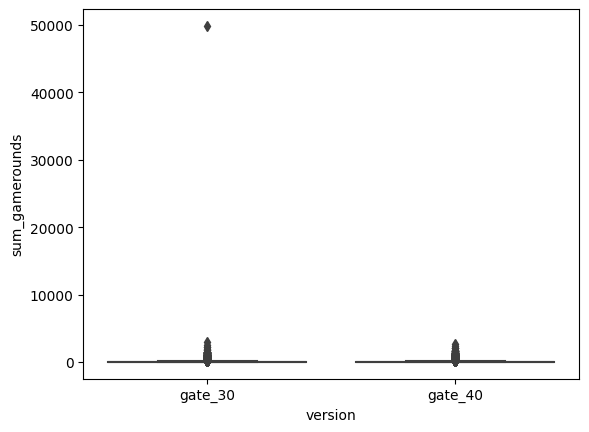

In [98]:
sns.boxplot(x=data['version'], y=data['sum_gamerounds']);

<div style='font-size: 16px'>
    Here it is, there is an extremely high value in gate_30 sample.
    <br>
    <br>Almost certainly it is an outlier, so we should remove it.
</div>

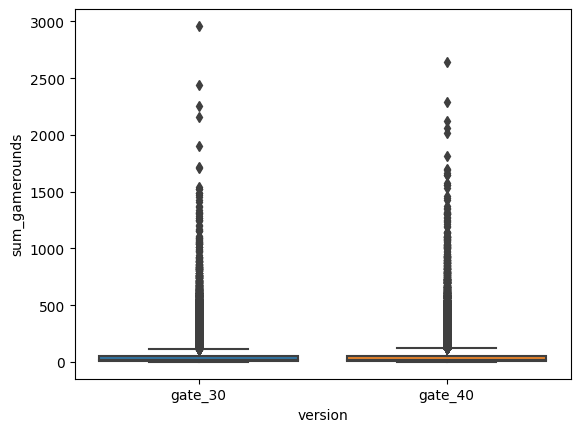

In [99]:
data = data[data['sum_gamerounds'] < 10000]
sns.boxplot(x=data['version'], y=data['sum_gamerounds']);

In [100]:
data.groupby('version')['sum_gamerounds'].agg(['mean', 'median', 'var'])

,mean,median,var
version,,,
gate_30,51.342111,17.0,10415.753288
gate_40,51.298776,16.0,10669.736422


<div style='font-size: 16px'>
    Now it doesn't look like the two boxplots are very different. Also, the variances have close values.
    <br>
    <br>Next, let's divide the data using the version column and build some plots, to compare the two samples.
</div>

In [101]:
control = data[data['version'] == 'gate_30']
test = data[data['version'] == 'gate_40']

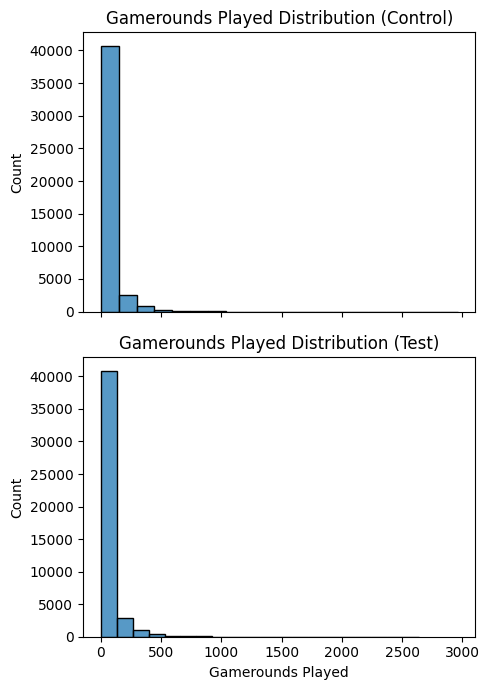

In [102]:
fig, ax = plt.subplots(2, 1, figsize = (5, 7), sharex=True)

sns.histplot(control['sum_gamerounds'], bins=20, ax=ax[0]);
ax[0].set_title("Gamerounds Played Distribution (Control)", fontsize=12);
ax[0].set_xlabel('Gamerounds Played');
sns.histplot(test['sum_gamerounds'], bins=20, ax=ax[1]);
ax[1].set_title("Gamerounds Played Distribution (Test)", fontsize=12);
ax[1].set_xlabel('Gamerounds Played');
fig.tight_layout();

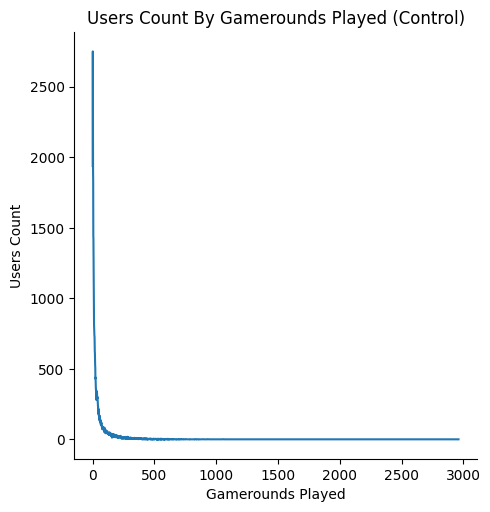

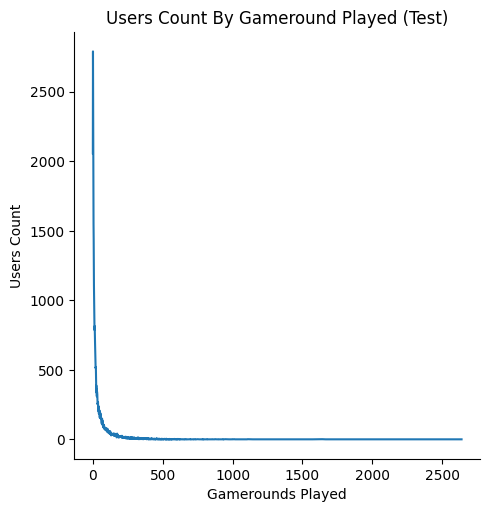

In [103]:
#fig, ax = plt.subplots(2, 1, figsize = (5, 7))

sns.relplot(control.groupby('sum_gamerounds')['userid'].count(), kind='line', ax=ax[0]);
plt.title("Users Count By Gamerounds Played (Control)", fontsize=12);
plt.xlabel('Gamerounds Played');
plt.ylabel('Users Count');
sns.relplot(test.groupby('sum_gamerounds')['userid'].count(), kind='line', ax=ax[1]);
plt.title("Users Count By Gameround Played (Test)", fontsize=12);
plt.xlabel('Gamerounds Played');
plt.ylabel('Users Count');

<div style='font-size: 16px'>
    The graphs look almost similar, and we can not see any big difference. Probably, there is no improvement in the number of played gamerounds with the new game version.
    <br> Also, we see that most users have only played a few rounds, and many of them have not played a single gameround.
    <br>
    <br>Since we have information about day 1 retention and day 7 retention, let's look at the rates for both samples as a part of the exploratory analysis.
</div>

In [109]:
print("-" * 20)
print("Day 1 retention rate:")
print("Control: %.3f" % (sum(control['retention_1']) / len(control)))
print("Test: %.3f" % (sum(test['retention_1']) / len(test)))
print("-" * 20)
print("Day 7 retention rate:")
print("Control: %.3f" % (sum(control['retention_7']) / len(control)))
print("Test: %.3f" % (sum(test['retention_7']) / len(test)))
print("-" * 20)

--------------------
Day 1 retention rate:
Control: 0.448
Test: 0.442
--------------------
Day 7 retention rate:
Control: 0.190
Test: 0.182
--------------------


<div style='font-size: 16px'>
    Retention rates are close for both samples (for control group they are slightly higher), and day 1 retention rate is higher than day 7 retention rate, which is reasonable since most users have only played a few rounds and then dropped the game.
    <br>
    <br>Next, we move on to statistical tests.
</div>

# <b>A/B testing</b> <a class="anchor"  id="ab"></a>

<div style='font-size: 16px'>
    It's time to choose a statistical test and see if the new version made any statistical difference in the number of gamerounds played by users.
    <br>Let's remember the hypotheses:
    <ul>
        <li><b>Null Hypothesis (H0)</b>: there is no statistical difference in terms of played gamerounds  between two game verisons;</li>
        <li><b>Alternative Hypothesis (H1)</b>: there is a statistical difference in terms of played gamerounds  between two game verisons.</li>
   </ul>
    <br>First of all, we need to check if the two samples are normally distributed. Normal distribution will allow us to use T-test.
    <br>Let's use Shapiro–Wilk test for that.
</div>

## <b>Shapiro–Wilk test</b> <a class="anchor"  id="swt"></a>

In [105]:
stat, pval = sts.shapiro(control['sum_gamerounds'])
print("Control p-value:", pval)
stat, pval = sts.shapiro(test['sum_gamerounds'])
print("Test p-value:", pval)

Control p-value: 0.0
Test p-value: 0.0


<div style='font-size: 16px'>
    The p-values are 0s for both samples, so we reject the null hypothesis for both samples, and we clearly see that they are not normally distributed.
    <br>
    <br>Since that, we should use non-parametric Mann-Whitney U test.
    <br>But, before we perform the test we need to make sure that there is no sum_gamerounds value that occurs more often than the rest combined.
</div>

In [107]:
pd.DataFrame({
    'control': control.groupby('sum_gamerounds')['userid'].count()[:30],
    'test': test.groupby('sum_gamerounds')['userid'].count()[:30]
})

,control,test
sum_gamerounds,,
0,1937,2057
1,2749,2789
2,2198,2408
3,1899,2059
4,1831,1798
5,1442,1550
6,1420,1441
7,1199,1180
8,1162,1105


<div style='font-size: 16px'>
    We do not meet such problem, so let's perform the test.
</div>

## <b>Mann-Whitney U test</b> <a class="anchor"  id="mwut"></a>

In [106]:
stat, pval = sts.mannwhitneyu(control['sum_gamerounds'], test['sum_gamerounds'])
print("P-value: ", pval)

P-value:  0.05089155279145376


<div style='font-size: 16px'>
    We received p-value that is approximately equal to the level of significance which is 0.05. We can not reject the null hypothesis, which states that there is no statistical difference in terms of played gamerounds  between two game verisons, since the p-value is not lower than 0.05.
</div>

# <b>Conclusion</b> <a class="anchor"  id="conclusion"></a>

<div style='font-size: 16px'>
    We worked with a dataset containing A/B test results for two version of the mobile game. After preprocessing and exploring the data, we performed the statistical test which showed us that there is no statistical significance between the two groups of users who started playing different versions of the game. We used Mann-Whitney U test, because the samples were not normally distributed, so we had to choose a non-parametric test. We got the p-value equal to 0.05089 which was slightly higher than the level of significance. Even though the p-value was low we were not able to reject the null hypothesis.
    <br>We conclude that there is no significant difference between the two versions of the game.
</div>